In [154]:
!pip install PySastrawi

In [155]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import csv
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Model, Sequential, load_model
from keras.layers import (Dense, Input, LSTM,Conv1D, Embedding, Dropout, Activation, GRU, Flatten,
                          Bidirectional, GlobalMaxPool1D, Convolution1D, MaxPooling1D, BatchNormalization)

from keras import losses
from keras.optimizers import Adam, SGD
from keras.metrics import Precision, Recall
from keras.callbacks import LearningRateScheduler, History ,EarlyStopping
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from keras import initializers, regularizers, constraints, optimizers, layers, losses, datasets

import pickle
import requests


In [156]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rizky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;color:white">Analysis Sentiment</p>

## <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:120%; text-align:center; border-radius: 15px 50px; color:white;">Table of Content</p>

* [1. Integration Data 💎](#1)
* [2. EDA 📊](#2)
    * [2.1 WordCloud 🛠](#2.1)
* [3. Data Preprocessing ⚙️](#3)
    * [3.1 Cleaning 🛠](#3.1)
    * [3.2 Processing 🛠](#3.2)
* [4. Extration Feature 📊](#4)
* [5. Tokenize & Padding](#5)
* [6. Modeling](#6)
* [7.Metric Evaluation](#7)
* [8.Testing Model](#8)


<a id='1'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">1. Integration Data 💎</p>

In [157]:
df1 = "https://raw.githubusercontent.com/meisaputri21/Indonesian-Twitter-Emotion-Dataset/master/Twitter_Emotion_Dataset.csv"
df1 = pd.read_csv(df1, lineterminator="\n")
df1 = df1[['tweet','label']].rename(columns={'tweet':'Tweet'})
df1

,Tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",anger
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",anger
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,happy
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",anger
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",happy
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",love
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,fear
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",anger
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,happy


In [158]:
# Mendefinisikan mapping dari emosi ke sentimen
emotion_to_sentiment = {
    'happy': 'positive',
    'love': 'positive',
    'anger': 'negative',
    'sadness': 'negative',
    'fear': 'negative'
}
# Mengubah label emosi menjadi label sentimen
df1['label'] = df1['label'].map(emotion_to_sentiment)
df1

,Tweet,label
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive
3,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng...",negative
4,"Sharing pengalaman aja, kemarin jam 18.00 bata...",positive
...,...,...
4396,"Tahukah kamu, bahwa saat itu papa memejamkan m...",positive
4397,Sulitnya menetapkan Calon Wapresnya Jokowi di ...,negative
4398,"5. masa depannya nggak jelas. lha iya, gimana ...",negative
4399,[USERNAME] dulu beneran ada mahasiswa Teknik U...,positive


In [159]:
df2 = pd.read_csv("https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/INA_TweetsPPKM_Labeled_Pure.csv", sep="\t")
df2.drop(columns=["Date", "User"], inplace=True)
df2.rename(columns={"sentiment": "label"}, inplace=True)
df2

,Tweet,label
0,Ketahui informasi pembagian #PPKM di wilayah J...,1
1,Tempat Ibadah di Wilayah PPKM Level 1 Boleh Be...,1
2,"Juru bicara Satgas Covid-19, Wiku Adisasmito m...",1
3,Ketahui informasi pembagian #PPKM di wilayah J...,1
4,Kementerian Agama menerbitkan Surat Edaran Nom...,1
...,...,...
23639,noelle loses a bet to akarsha and it somehow e...,1
23640,they call her... weekeeshee...\n#butterflysoup...,1
23641,"put out what you wanna see more of, amirite ga...",1
23642,"i don't need anybody, i'm fine here on my own\...",1


In [160]:
# Menghitung jumlah baris untuk setiap label
label_counts = df2['label'].value_counts()
# Mengambil 70% dari baris dengan label 'neutral'
neutral_rows = df2[df2['label'] == 1]
reduced_neutral_rows = neutral_rows.sample(n=int(len(neutral_rows)*0.3), random_state=1)
# Mengambil semua baris dengan label selain 'neutral'
other_rows = df2[df2['label'] != 1]
# Menggabungkan baris yang telah direduksi dengan baris lainnya
df2 = pd.concat([other_rows, reduced_neutral_rows])
df2

,Tweet,label
33,Karena stimulasi untuk #anakberkebutuhankhusus...,2
35,Hadir Kembali Boss!! MEGA WIN Dari https://t.c...,0
44,Hayolohhhhhhhhh... seneng kannnn??\n\n#covid19...,0
47,Thank You teman-teman dari #saganheritagehotel...,0
51,Ruwet Ruwet Ruwet inilah Negeri RuwetNesia. He...,0
...,...,...
5643,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,1
17877,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,1
12817,Jadi di perpanjang atau stop sampai hari ini s...,1
4932,Polres Kepulauan Seribu Terus bagikan masker d...,1


In [161]:
number_to_sentiment = {
    0: 'positive',
    1: 'neutral',
    2: 'negative'
}
df2['label'] = df2['label'].map(number_to_sentiment)
df2

,Tweet,label
33,Karena stimulasi untuk #anakberkebutuhankhusus...,negative
35,Hadir Kembali Boss!! MEGA WIN Dari https://t.c...,positive
44,Hayolohhhhhhhhh... seneng kannnn??\n\n#covid19...,positive
47,Thank You teman-teman dari #saganheritagehotel...,positive
51,Ruwet Ruwet Ruwet inilah Negeri RuwetNesia. He...,positive
...,...,...
5643,Satpol PP Sidak Pelaksanaan Sekolah Tatap Muka...,neutral
17877,Perlakuan Petugas PPKM Darurat ke Paspamres Da...,neutral
12817,Jadi di perpanjang atau stop sampai hari ini s...,neutral
4932,Polres Kepulauan Seribu Terus bagikan masker d...,neutral


In [162]:
df = pd.concat([df1, df2], ignore_index=True)

<a id='1'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">1. EDA</p>

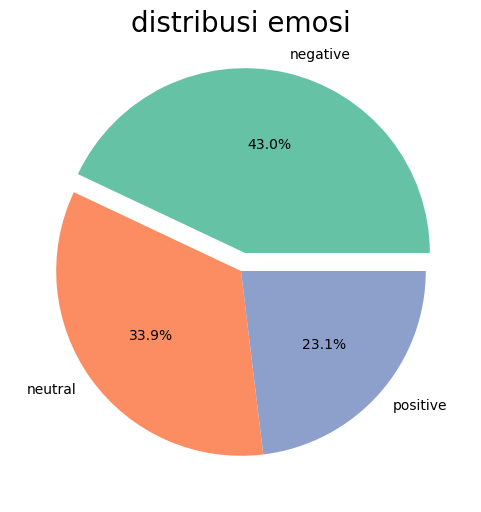

In [163]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in df['label'].value_counts()]
labels = list(df['label'].value_counts().index)
explode = (0.1, 0, 0)  # Offset the first segment
# Gunakan palet warna Seaborn
colors = sns.color_palette('Set2')
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, colors=colors, textprops={'fontsize': 10})
ax.set_title('distribusi emosi', fontsize = 20)
plt.show()

<a id='2.1'></a>
## <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">2.1 Word Cloud 💎</p>

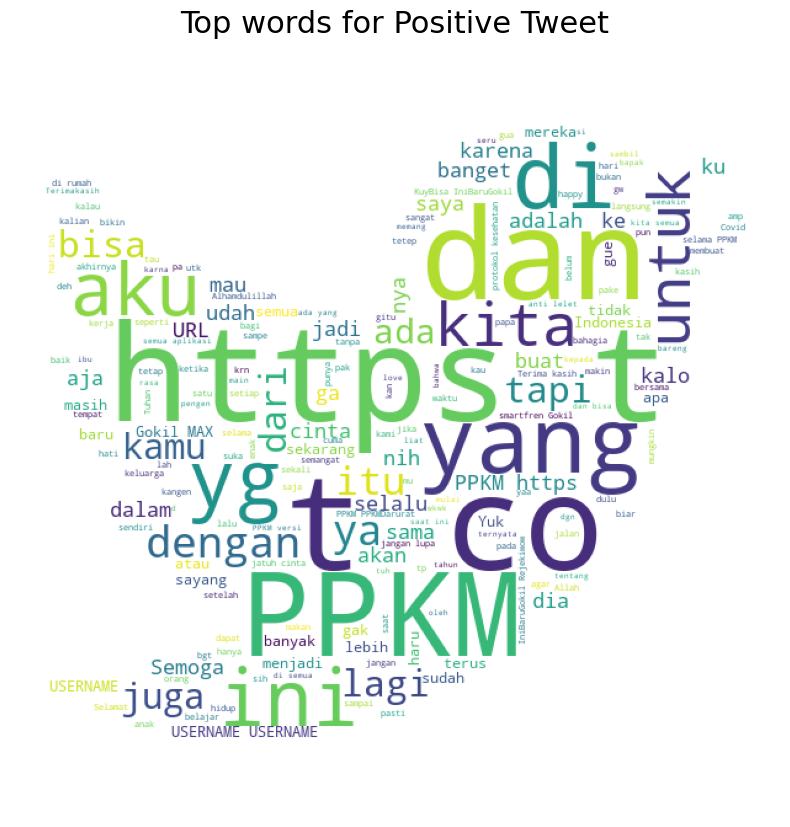

In [164]:
import requests
from PIL import Image
from io import BytesIO

url = "https://image.freepik.com/free-icon/twitter-logo_318-40459.jpg"  # replace with your image URL
response = requests.get(url)
twitter_mask = np.array(Image.open(BytesIO(response.content)))

wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'positive', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Positive Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

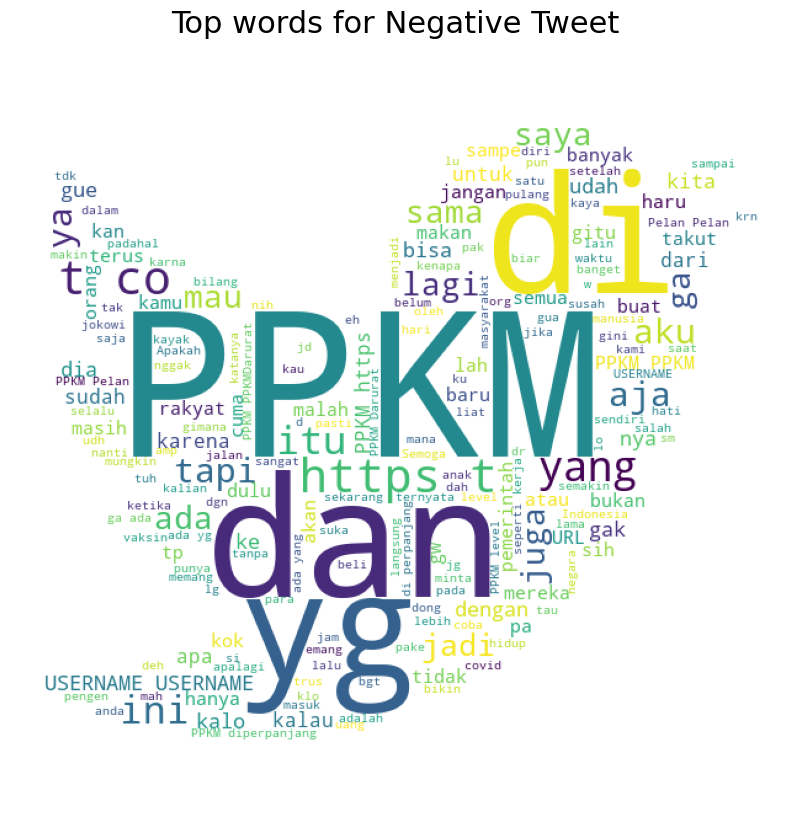

In [165]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'negative', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Negative Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

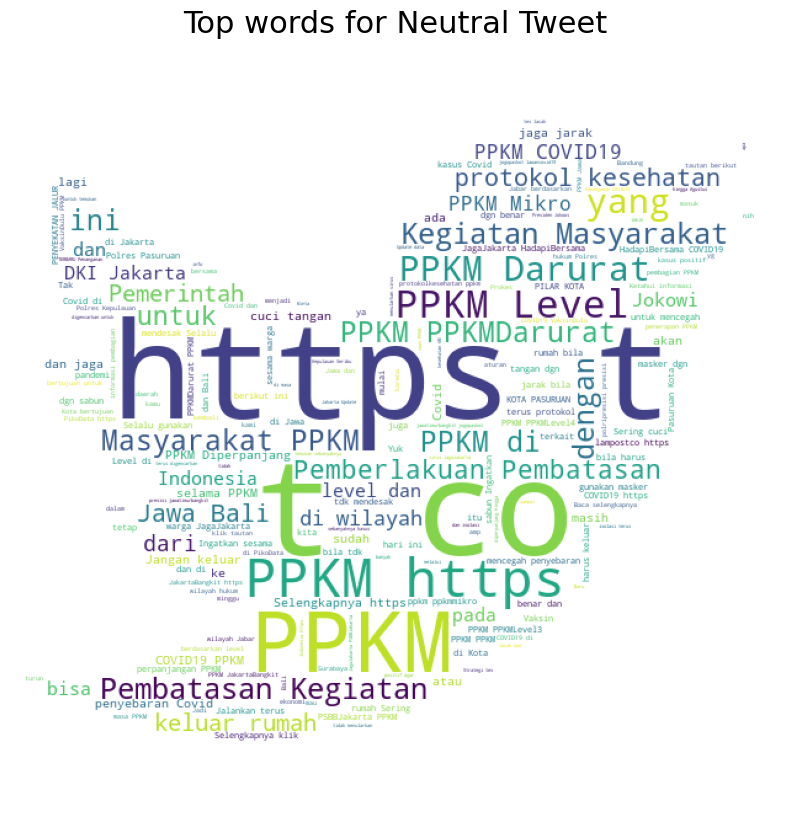

In [166]:
wc = WordCloud(
    background_color='white',
    max_words=200,
    mask=twitter_mask,
)
wc.generate(' '.join(text for text in df.loc[df['label'] == 'neutral', 'Tweet']))
plt.figure(figsize=(18,10))
plt.title('Top words for Neutral Tweet',
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

<a id='3'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">3. Data Preprocessing 💎</p>

In [167]:
stopword_bahasa = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/stopwordbahasa.csv', encoding='latin-1')
stopword_bahasa = stopword_bahasa.rename(columns={0: 'stop'})
stopword_bahasa.head()

,ada
0,adalah
1,adanya
2,adapun
3,agak
4,agaknya


In [168]:
kamus_alay = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_alay.csv', header=None, encoding='latin-1')
kamus_alay = kamus_alay.rename(columns={0: 'original',
                                     1: 'replacement'})
kamus_alay_map = dict(zip(kamus_alay['original'], kamus_alay['replacement']))
kamus_alay.head()

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali


In [169]:
kamus_singkatan = pd.read_csv('https://raw.githubusercontent.com/rizky-22017-mhs-unesa-ac-id/Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X/main/Dataset/TextNormalization/kamus_singkatan.csv', sep=';', encoding='latin-1')
kamus_singkatan.columns = ['Column1', 'Column2']
kamus_singkatan = kamus_singkatan.rename(columns={'Column1': 'original', 'Column2': 'replacement'})
kamus_singkatan_map = dict(zip(kamus_singkatan['original'], kamus_singkatan['replacement']))
kamus_singkatan.head()

,original,replacement
0,adek,adik
1,adlh,adalah
2,aer,air
3,aiskrim,es krim
4,aj,saja


<a id='3.1'></a>
## <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">3.1 Cleaning 💎</p>

In [170]:
# List of words to remove
remove_words = ['ppkm', 'covid']

def remove_unnecessary_char(text):
    text = text.lower()
    text = re.sub('\n', ' ', text) # Remove every newline character
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text) # Remove every username
    text = re.sub('user', ' ', text) # Remove every occurrence of the word 'user'
    text = re.sub('rt', ' ', text) # Remove every retweet symbol
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text) # Remove every URL
    text = re.sub('https?://t\.me/[^\s]+', ' ', text) # Remove every Telegram link
    text = re.sub ('[^0-9a-zA-Z]+', ' ', text) # Remove every non-alphanumeric character
    text = re.sub('  +', ' ', text) # Remove extra spaces
    for word in remove_words:
        text = re.sub(word, '', text)  # remove word
    return text
df["cleaning"] = df.Tweet.apply(lambda text: remove_unnecessary_char(text))
df.head(3)

,Tweet,label,cleaning
0,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu...",negative,soal jln jatibaru polisi tdk bs ge ak gubernur...
1,"Sesama cewe lho (kayaknya), harusnya bisa lebi...",negative,sesama cewe lho kayaknya harusnya bisa lebih r...
2,Kepingin gudeg mbarek Bu hj. Amad Foto dari go...,positive,kepingin gudeg mbarek bu hj amad foto dari goo...


<a id='3.2'></a>
## <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">3.2 Normalization 💎</p>

In [171]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Text preprocessing functions from previous script
def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text)
    return text
def transform_emoticons(text):
    text = text.replace("<3", "<love>")
    text = text.replace(":p", "<mengejek>")
    text = text.replace(":P", "<mengejek>")
    text = text.replace(":v", "<melucu>")
    text = text.replace(":V", "<melucu>")
    text = text.replace(":d", "<tertawa>")
    text = text.replace(":D", "<tertawa>")
    text = text.replace(":-D", "<tertawa>")
    text = text.replace(":o", "<terkejut>")
    text = text.replace(":O", "<terkejut>")
    text = text.replace("xD", "<tertawa terbahak bahak>")
    text = text.replace("XD", "<tertawa terbahak bahak>")
    text = text.replace(":*", "<mencium>")
    text = text.replace(":3", "<malu malu kucing>")
    text = text.replace("-__-", "<wajah datar>")
    text = text.replace("-_-", "<wajah datar>")
    text = text.replace(":|", "<wajah datar>")
    text = text.replace(":\\", "<terganggu>")
    text = text.replace(":/", "<terganggu>")
    text = text.replace(":))", "<senyum>")
    text = text.replace(":)", "<senyum>")
    text = text.replace(":-))", "<senyum>")
    text = text.replace(":-)", "<senyum>")
    text = text.replace("^^", "<senyum>")
    text = text.replace("^_^", "<senyum>")
    text = text.replace(";))", "<senyum berkedip>")
    text = text.replace(";)", "<senyum berkedip>")
    text = text.replace(":((", "<sedih>")
    text = text.replace(":(", "<sedih>")
    text = text.replace(":-((", "<sedih>")
    text = text.replace(":-(", "<sedih>")
    text = text.replace(":'((", "<menangis sedih>")
    text = text.replace(":'(", "<menangis sedih>")
    text = text.replace(":'))", "<menangis bahagia>")
    text = text.replace(":')", "<menangis bahagia>")
    text = text.replace(":'", "<menangis sedih>")
    text = text.replace(":’((", "<menangis sedih>")
    text = text.replace(":’(", "<menangis sedih>")
    text = text.replace(":’))", "<menangis bahagia>")
    text = text.replace(":’)", "<menangis bahagia>")
    text = text.replace(":’", "<menangis sedih>")
    text = text.replace(":\"((", "<menangis sedih>")
    text = text.replace(":\"(", "<menangis sedih>")
    text = text.replace(":\"))", "<menangis bahagia>")
    text = text.replace(":\")", "<menangis bahagia>")
    text = text.replace(":\"", "<menangis sedih>")
    text = text.replace(":\"D", "<menangis bahagia>")
    text = text.replace("TT", "<menangis sedih>")
    return text

def normalize_alay(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

def normalize_singkatan(text):
    return ' '.join([kamus_singkatan_map[word] if word in kamus_singkatan_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join([ ' ' if word in stopword_bahasa.ada.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  return do

# Modified clean_text function that calls preprocessing functions from previous script
def preprocess(text):
    text = normalize_alay(text) # Normalize text using alay_dict_map
    text = normalize_singkatan(text) # Normalize text using alay_dict_map2
    text = remove_stopword(text) # Remove stopwords from text
    text = tokenizingText(text)
    text = stemming(text)
    return text
# df['preprocessing'] = df['cleaning'].apply(preprocess)
# df

In [172]:
# Apply data processing to each tweet
X = list(map(preprocess, df['cleaning']))

In [173]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['label'])

In [174]:
print(X[100])
print(Y[100])

['nama', 'be', 'anya', 'obrol', 'mbak', 'mbak', 'help', 'desk', 'nge', 'i', 'pe', 'anyaan', 'mbak', 'emosi', 'ya', 'jawab', 'pulang']
0


<a id='4'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">4 Extraction Feature 💎</p>

In [175]:
y = pd.get_dummies(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [176]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
vocabulary_size = 5000
# Tweets have already been preprocessed hence dummy function will be passed in
# to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
#                               ngram_range=(1,2),    # unigram and bigram
                                preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()
# Transform testing data
X_test = count_vector.transform(X_test).toarray()

c:\Users\rizky\anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


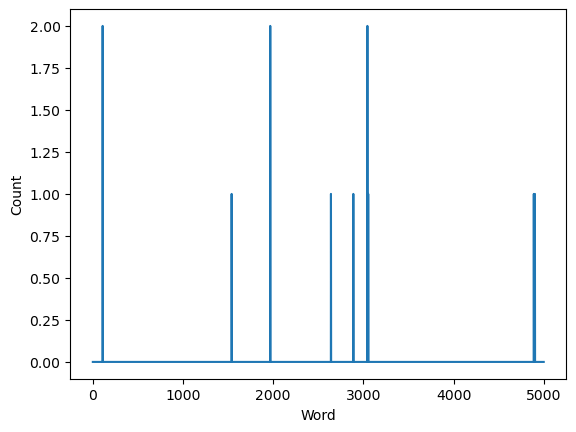

In [177]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

<a id='5'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">5 Tokenize & Padding 💎</p>

In [178]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer
print('Before Tokenization & Padding \n', df['cleaning'][0])
X, tokenizer = tokenize_pad_sequences(df['cleaning'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 soal jln jatibaru polisi tdk bs ge ak gubernur emangny polisi tdk ikut pmbhasan jgn berpolitik pengaturan wilayah hak gubernur persoalan tn abang soal turun temurun pelik perlu kesabaran name name url 
After Tokenization & Padding 
 [ 418 1336  586  183  690 3677 1737  500  586  183  379  567 4403  151
 1453  500 4010 1305  418  262  234 2674    9    9   64    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [179]:
import pickle
# saving
with open('tokenizer_bow.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
# loading
with open('tokenizer_bow.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

<a id='6'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">6. Modelling 💎</p>

In [180]:
y = pd.get_dummies(df['label'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (9390, 50) (9390, 3)
Validation Set -> (3130, 50) (3130, 3)
Test Set -> (3130, 50) (3130, 3)


In [181]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [193]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

vocab_size = 5000
embedding_size = 32
epochs=50
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

# Membuat callback untuk early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Membuat jadwal learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=0.9)

# Membuat optimizer
sgd = SGD(learning_rate=lr_schedule, momentum=momentum, nesterov=False)

# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))


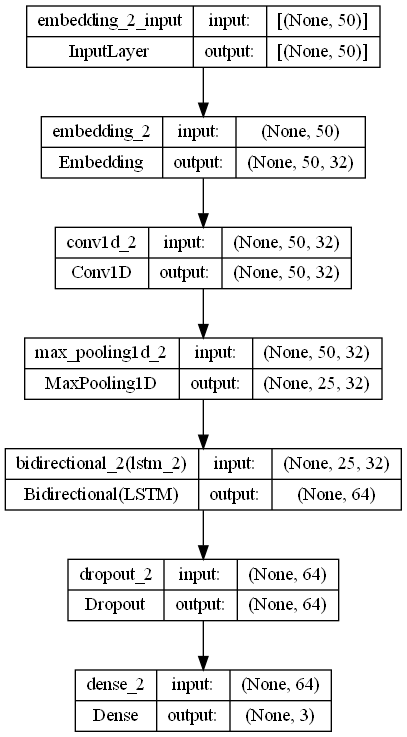

In [194]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [195]:
print(model.summary())
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])
# Train model
batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1,
                      callbacks=[early_stop])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                

<a id='7'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">7. Metric Evaluation 💎</p>

In [196]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.7668
Precision : 0.7727
Recall    : 0.7604
F1 Score  : 0.7665


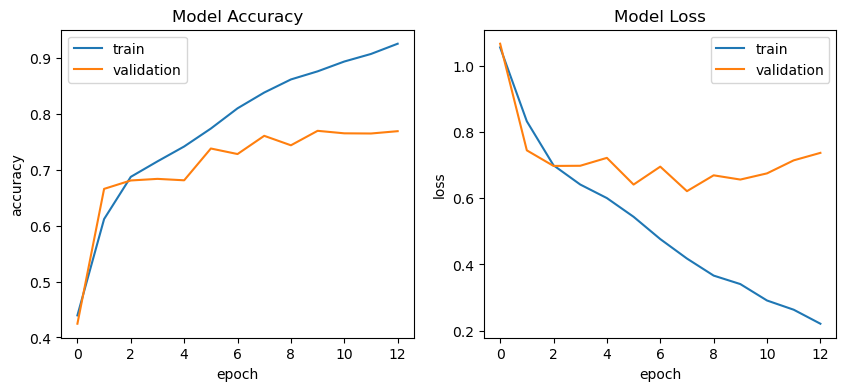

In [197]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

98/98 [==============================] - 1s 7ms/step


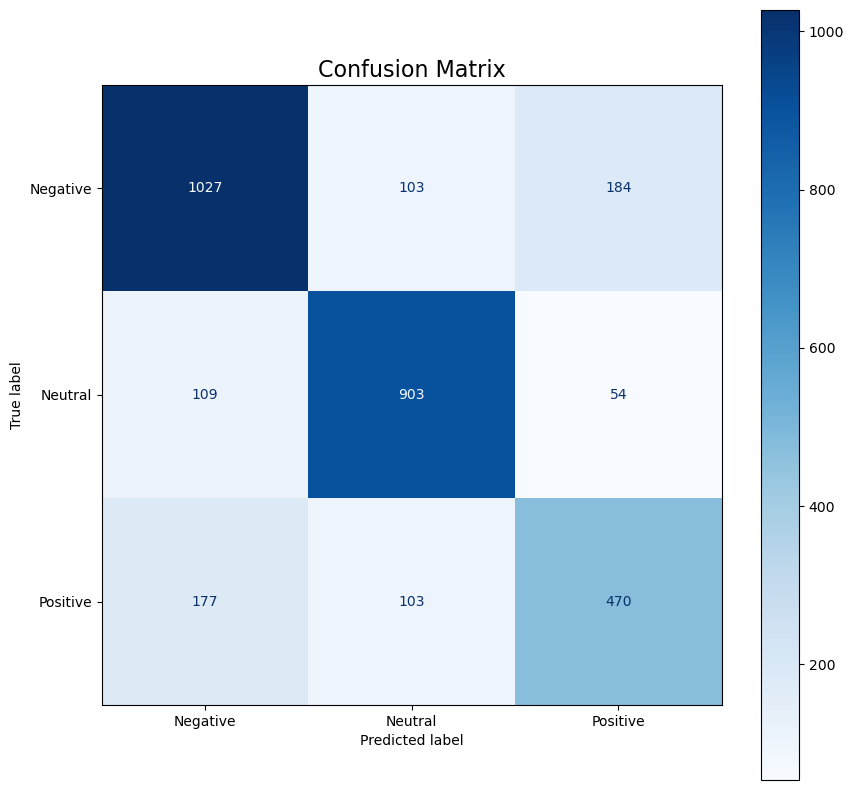

In [198]:
from sklearn.metrics import ConfusionMatrixDisplay

# Use model to do the prediction
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))

# Define the labels
labels = ['Negative', 'Neutral', 'Positive']

# Create a ConfusionMatrixDisplay instance
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix using the plot method of ConfusionMatrixDisplay
plt.figure(figsize=(10,10))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Confusion Matrix', fontsize=16)
plt.show()

In [199]:
# Save the model architecture & the weights
model.save('best_model_bow.h5')
print('Best model saved')

Best model saved


<a id='8'></a>
# <p style="background-color:#6DC5D1; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;color:white">8. Testing Model 💎</p>

In [200]:
from keras.models import load_model

# Load model
model = load_model(r'C:\Users\rizky\OneDrive\Dokumen\GitHub\Sentiment-Analysis-of-KIP-Recipients-based-on-Tweets-from-X\best_model_bow.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [209]:
predict_class(['saking bagus nya program kipk sampai sampai tidak tepat sasaran'])

1/1 [==============================] - 0s 23ms/step
The predicted sentiment is Negative


In [191]:
predict_class(['saking bagus nya program kipk sampai sampai tidak tepat sasaran'])

1/1 [==============================] - 0s 39ms/step
The predicted sentiment is Negative


In [192]:
predict_class(['sistem seleksi KIPK perlu di perbaiki'])

1/1 [==============================] - 0s 33ms/step
The predicted sentiment is Neutral
